### Imports

In [168]:
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import cauchy
from scipy.stats import uniform
from scipy.stats import laplace
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy.integrate import quad, tplquad
from scipy.optimize import curve_fit
import pickle as pkl
from numba import njit, jit, prange, cuda
import numba

rng = np.random.default_rng()

## Part 1 -FCC Lattice

In [210]:
def simulate_FCC_lattice_rw(n_walkers, n_steps, S_0):
  steps = rng.choice(0.5*np.array([[1,1,0],[1,-1,0],[-1,1,0],[-1,-1,0],[0,1,1],[0,-1,1],[0,1,-1],[0,-1,-1],[1,0,1],[-1,0,1],[1,0,-1],[-1,0,-1]]), size=(n_walkers,n_steps))
  steps = np.insert(steps, 0, S_0, axis=1) #
  steps = steps.astype(np.float16)
  trajectories = np.array(np.cumsum(steps, axis=1)) #calculates the positions after each step
  return trajectories

def simulate_BCC_lattice_rw(n_walkers, n_steps, S_0):
  steps = rng.choice(0.5*np.array([[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1]]), size=(n_walkers,n_steps))
  steps = np.insert(steps, 0, S_0, axis=1) #
  steps = steps.astype(np.float16)
  trajectories = np.array(np.cumsum(steps, axis=1)) #calculates the positions after each step
  return trajectories

def simulate_2D_sym_rw(n_walkers, n_steps  , S_0):
  steps = rng.choice([[1,0],[-1,0],[0,1],[0,-1]], size=(n_walkers,n_steps))
  steps = np.insert(steps, 0, S_0, axis=1) #
  steps = steps.astype(np.float16)
  trajectories = np.array(np.cumsum(steps, axis=1)) #calculates the positions after each step
  return trajectories


In [211]:
n_walkers = int(1E6)
n_steps = 100

In [212]:
### FCC RW ###
S_0 = [0,0,0]
fcc_trajectories = simulate_FCC_lattice_rw(n_walkers, n_steps, S_0)
np.save('Question_2_data/FCC_trajectories_(b).npy', fcc_trajectories)

In [213]:
### BCC RW ###
S_0 = [0,0,0]
bcc_trajectories = simulate_BCC_lattice_rw(n_walkers, n_steps, S_0)
np.save('Question_2_data/BCC_trajectories_(b).npy', bcc_trajectories)

In [214]:
### 2D Symmetric RW ###
S_0 = [0,0]
sym_2d_trajectories = simulate_2D_sym_rw(n_walkers, n_steps, S_0)
np.save('Question_2_data/sym_2d_trajectories_(b).npy', sym_2d_trajectories)

In [215]:
distances_fcc = np.linalg.norm(fcc_trajectories, axis=2)
MSD_FCC = np.mean(distances_fcc**2, axis=0)
theoretical_MSD_FCC = lambda n: 0.5*n

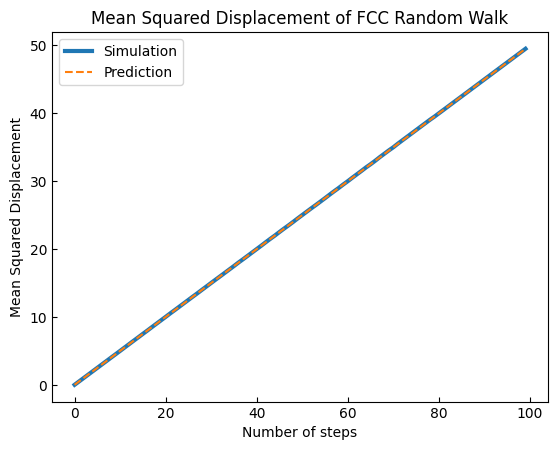

In [216]:
### Plotting ###
n_print = 100
plt.plot(MSD_FCC[0:n_print], label='Simulation', linewidth=3)
plt.plot(theoretical_MSD_FCC(np.arange(n_print)), label='Prediction', linestyle='--')
plt.xlabel('Number of steps')
plt.ylabel('Mean Squared Displacement')
plt.title('Mean Squared Displacement of FCC Random Walk')
plt.legend()
plt.tick_params(direction='in')
plt.savefig('Question_2_plots/FCC_MSD_(a).png', dpi=300)

In [217]:
theoretical_MSD_2D = lambda n: n
theoretical_MSD_BCC = lambda n: n*0.75
MSD_2D = np.mean(np.linalg.norm(sym_2d_trajectories, axis=2)**2, axis=0)
MSD_BCC = np.mean(np.linalg.norm(bcc_trajectories, axis=2)**2, axis=0)

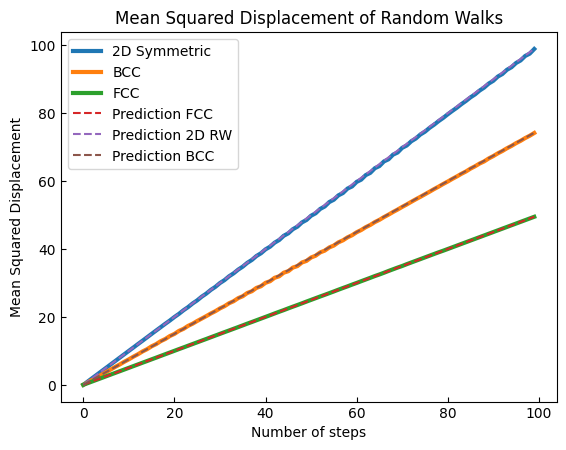

In [218]:
### Plot MSDs ###
plt.plot(MSD_2D[:n_print], label='2D Symmetric', linewidth=3)
plt.plot(MSD_BCC[:n_print], label='BCC', linewidth=3)
plt.plot(MSD_FCC[:n_print], label='FCC', linewidth=3)
plt.plot(theoretical_MSD_FCC(np.arange(n_print)), label='Prediction FCC', linestyle='--')
plt.plot(theoretical_MSD_2D(np.arange(n_print)), label='Prediction 2D RW', linestyle='--')
plt.plot(theoretical_MSD_BCC(np.arange(n_print)), label='Prediction BCC', linestyle='--')
plt.xlabel('Number of steps')
plt.ylabel('Mean Squared Displacement')
plt.title('Mean Squared Displacement of Random Walks')
plt.legend()
plt.tick_params(direction='in')
plt.savefig('Question_2_plots/MSD_(b).png', dpi=300)


In [219]:
def fit_func(x, a):
    return a*x

### fit FCC lattice ###
popt, pcov = curve_fit(fit_func, np.arange(n_print), MSD_FCC[:n_print])
a_fcc = popt[0]

### fit BCC lattice ###
popt, pcov = curve_fit(fit_func, np.arange(n_print), MSD_BCC[:n_print])
a_bcc = popt[0]

### fit 2D symmetric lattice ###
popt, pcov = curve_fit(fit_func, np.arange(n_print), MSD_2D[:n_print])
a_2d = popt[0]


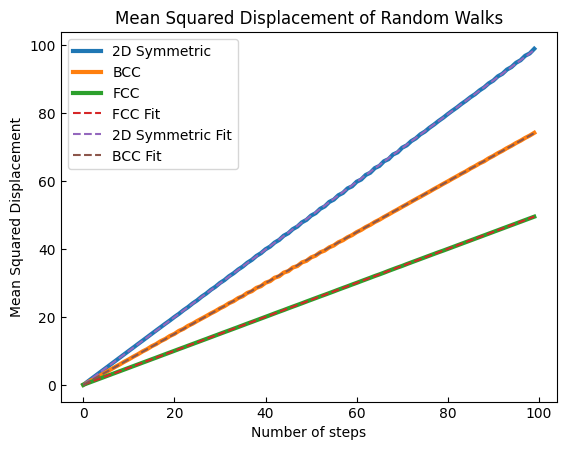

In [220]:
### Plot the fits ###
plt.plot(MSD_2D[:n_print], label='2D Symmetric', linewidth=3)
plt.plot(MSD_BCC[:n_print], label='BCC', linewidth=3)
plt.plot(MSD_FCC[:n_print], label='FCC', linewidth=3)
plt.plot(fit_func(np.arange(n_print), a_fcc), label='FCC Fit', linestyle='--')
plt.plot(fit_func(np.arange(n_print), a_2d), label='2D Symmetric Fit', linestyle='--')
plt.plot(fit_func(np.arange(n_print), a_bcc), label='BCC Fit', linestyle='--')
plt.xlabel('Number of steps')
plt.ylabel('Mean Squared Displacement')
plt.title('Mean Squared Displacement of Random Walks')
plt.legend()
plt.tick_params(direction='in')
plt.savefig('Question_2_plots/MSD_fits_(b).png', dpi=300)

In [221]:
def FCC_characteristic_function(x,y,z):
    return (1/3)*(np.cos(x)*np.cos(y) + np.cos(y)*np.cos(z) + np.cos(x)*np.cos(z))

integrand = lambda x,y,z: ((1/np.pi)**3)*(1/(1-FCC_characteristic_function(x,y,z)))
P_0 = tplquad(integrand, 0, np.pi, 0, np.pi, 0, np.pi)[0]
print(P_0)
F_0 = 1 - 1/P_0
print(F_0)


1.3446611831618778
0.25631823650284213


$P( \vec O, 1) = 1.34466$

The fact that we got a finite value (We only simulated 1000 stpes but still this is a relativly small value (does not diverges)) for this sum of probablities means that our walker in transient. (For a recurrent walker this sum is infinite)

We know that the probability to eventually return:

$F(\vec{O}, 1) = 1 - \frac{1}{P( \vec O, 1)} = 0.256$

In [222]:
### Find first index where walker is at [0,0,0] ###
fcc_distances = np.linalg.norm(fcc_trajectories[:,1:,:], axis=2)
fcc_distances_flag = fcc_distances == 0
reached_origin = np.sum(fcc_distances_flag, axis=1) != 0
first_zero_index = np.argmin(fcc_distances, axis=1)
steps_reached_origin = np.extract(reached_origin, first_zero_index)
steps, counts = np.unique_counts(steps_reached_origin)
return_prob = np.cumsum(counts)/1E6

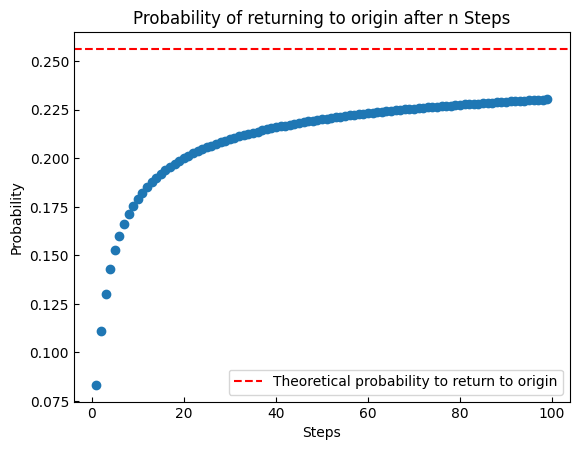

In [223]:
plt.plot(steps, return_prob, 'o')
plt.xlabel('Steps')
plt.ylabel('Probability')
plt.title('Probability of returning to origin after n Steps')
plt.tick_params(direction='in')
plt.axhline(F_0, color='r', linestyle='--', label='Theoretical probability to return to origin')
plt.legend()
plt.savefig('Question_2_plots/steps_to_origin_(b).png', dpi=300)

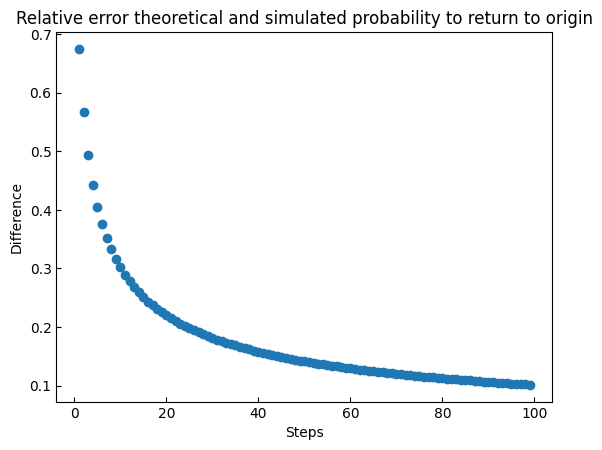

In [224]:
### calculate difference from theoretical value ###
diff = np.abs(return_prob - F_0)
err = diff/F_0
plt.plot(steps, err, 'o')
plt.xlabel('Steps')
plt.ylabel('Difference')
plt.title('Relative error theoretical and simulated probability to return to origin')
plt.tick_params(direction='in')
plt.savefig('Question_2_plots/return_prob_difference_from_theo_(b).png', dpi=300)

In [225]:
@jit(nopython=True) #how to use numba
### function that finds the distinct sites visited at each step per walker
def distinct_sites_visited_one_walker(arr):
    n = len(arr)
    unique_counts = [0] * n
    seen = set()
    count = 0

    for i, num in enumerate(arr):
        num = (num[0], num[1], num[2])
        if num not in seen:
            count += 1
            seen.add(num)
        unique_counts[i] = count

    return unique_counts

In [226]:
#@njit(parallel=True)
def get_uniques_N_walkers(trajectories):
  n_walkers = len(trajectories)
  n_steps = len(trajectories[0])
  unique_amounts_per_n_per_traj = np.zeros((n_walkers, n_steps))  # Pre-allocate output array

  for i in prange(n_walkers):
      unique_amounts_per_n_per_traj[i] = distinct_sites_visited_one_walker(trajectories[i])

  return unique_amounts_per_n_per_traj

In [227]:
fcc_trajectories = fcc_trajectories.astype(float)
unique_amounts_per_n = get_uniques_N_walkers(fcc_trajectories)

In [228]:
means = np.mean(unique_amounts_per_n, axis=0) - 1
stds = np.std(unique_amounts_per_n, axis=0)

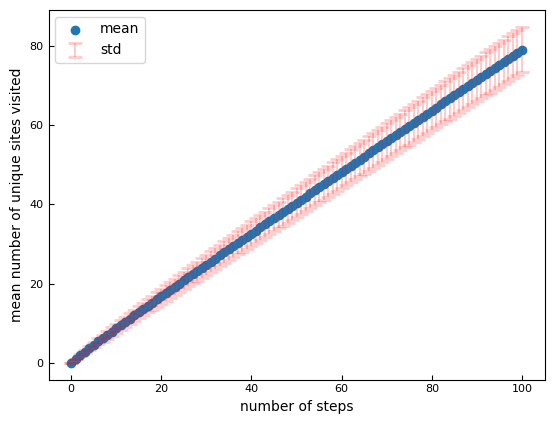

In [229]:
### plot mean number of sites visited with std as error bar by number of steps ###
plt.scatter(range(len(means)), means, label='mean')
plt.errorbar(
    range(len(means)),
    means,
    yerr=stds,
    label='std',
    fmt='none',
    capsize=5,  # Length of the horizontal bars
    capthick=2, # Thickness of the horizontal bars
    color='red', # Change color to red
    alpha=0.2 )  # Set opacity to 50%
plt.legend()
plt.xlabel('number of steps')
plt.ylabel('mean number of unique sites visited')
plt.tick_params(axis='both', which='both', labelsize=8, direction='in')
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\g'
C:\Users\nir19\AppData\Local\Temp\ipykernel_33464\2057028271.py:19: SyntaxWarning: invalid escape sequence '\g'
  plt.axvline(x=index_n_big, color='black', linestyle='--', label='n $\gg$ 1')


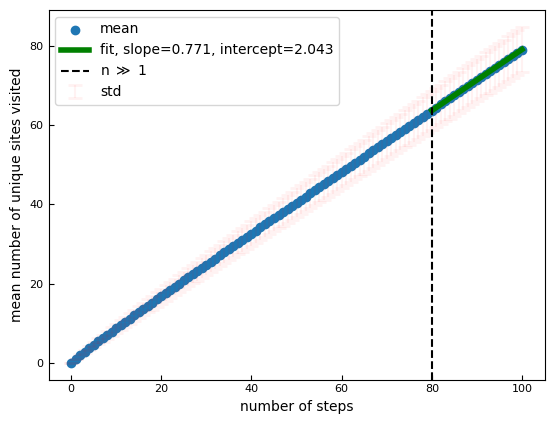

In [238]:
index_n_big = 80
x = range(len(means))[index_n_big:]
y = means[index_n_big:]
coeffs = np.polyfit(x, y, 1)
slope = coeffs[0]
### plot mean number of sites visited with std as error bar by number of steps ###
plt.scatter(range(len(means)), means, label='mean')
plt.errorbar(
    range(len(means)),
    means,
    yerr=stds,
    label='std',
    fmt='none',
    capsize=5,  # Length of the horizontal bars
    capthick=2, # Thickness of the horizontal bars
    color='red', # Change color to red
    alpha=0.05 )  # Set opacity to 50%
plt.plot(x, coeffs[1] + x*slope, label=f'fit, slope={slope:.3f}, intercept={coeffs[1]:.3f}', color='g', linewidth=4)
plt.axvline(x=index_n_big, color='black', linestyle='--', label='n $\gg$ 1')
plt.legend()
plt.xlabel('number of steps')
plt.ylabel('mean number of unique sites visited')
plt.tick_params(axis='both', which='both', labelsize=8, direction='in')
plt.show()

The slope is the prefactor for n is the equation from the tauberian theorem and:

$S(z) = \frac{1}{(1-z)^2P(\vec{0},z)}-\frac{1}{1-z}$

From this using the theorem and taking $z \rightarrow 1$ we get that the prefactor for n is:

$\frac{1}{P( \vec O, 1)}$

$P( \vec O, 1) = \frac{1}{slope} = 1.287$

The fact that we got a finite value (We only simulated 10000 stpes but still this is a relativly small value (does not diverges)) for this sum of probablities means that our walker in transient. (For a recurrent walker this sum is infinit)

We know that:

$F(\vec{O}, 1) = 1 - \frac{1}{P( \vec O, 1)} = 0.223 \approx 0.256$

In [239]:
rel_error = 100*(1-(1-slope)/F_0)
print(f'The relative error is {rel_error:.2f}%')

The relative error is 10.61%
